In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import src.bayesian_stats as bst

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.2.2


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.95
#rng = np.random.default_rng(seed=42)


In [3]:
df = pd.read_csv('../kruschke_data/Guber1999data.csv')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   State      50 non-null     object 
 1   Spend      50 non-null     float64
 2   StuTeaRat  50 non-null     float64
 3   Salary     50 non-null     float64
 4   PrcntTake  50 non-null     int64  
 5   SATV       50 non-null     int64  
 6   SATM       50 non-null     int64  
 7   SATT       50 non-null     int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 3.2+ KB


In [4]:
df.head()

State  Spend  StuTeaRat  Salary  PrcntTake  SATV  SATM  SATT
0     Alabama  4.405       17.2  31.144          8   491   538  1029
1      Alaska  8.963       17.6  47.951         47   445   489   934
2     Arizona  4.778       19.3  32.175         27   448   496   944
3    Arkansas  4.459       17.1  28.934          6   482   523  1005
4  California  4.992       24.0  41.078         45   417   485   902

In [5]:
X = df[["Spend", "PrcntTake"]]
y = df["SATT"]

_, mu_X, sigma_X = bst.standardize(X)
_, mu_y, sigma_y = bst.standardize(y)

In [6]:
mu_X.shape

(2,)

In [7]:
model, idata = bst.multiple_linear_regression(X, y)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta, nu_minus_one, nu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


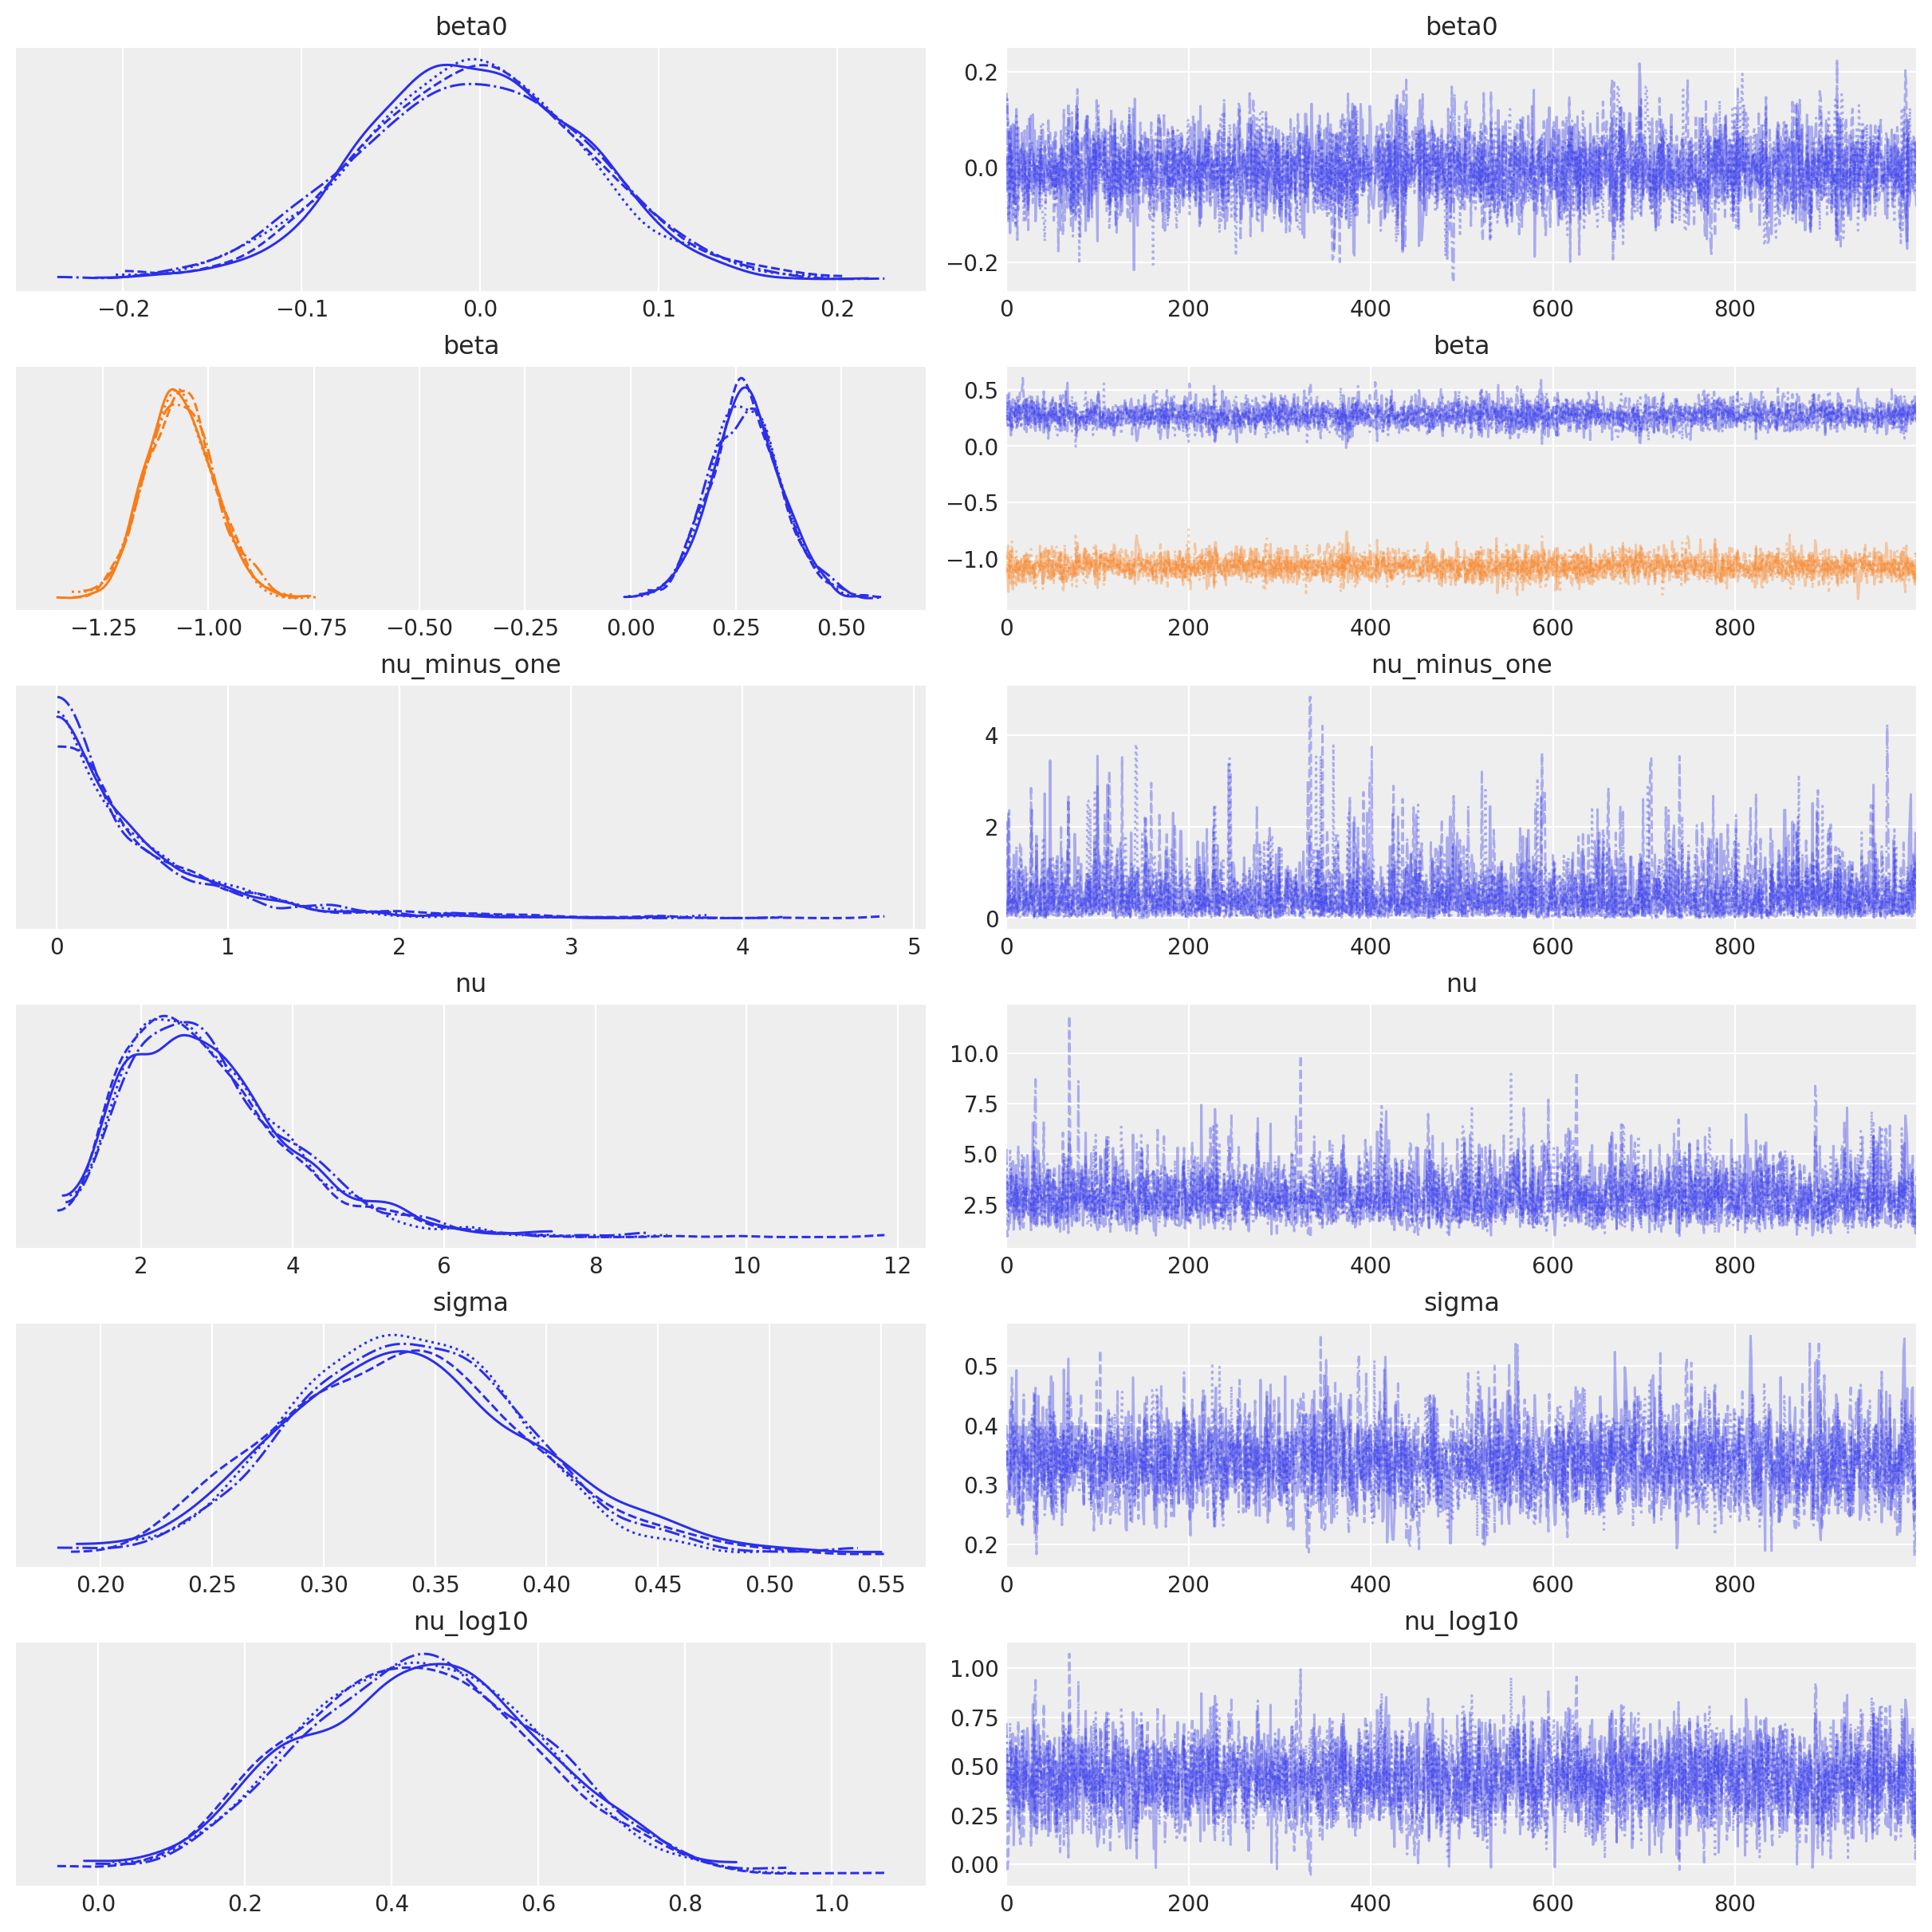

In [8]:
pm.plot_trace(idata);

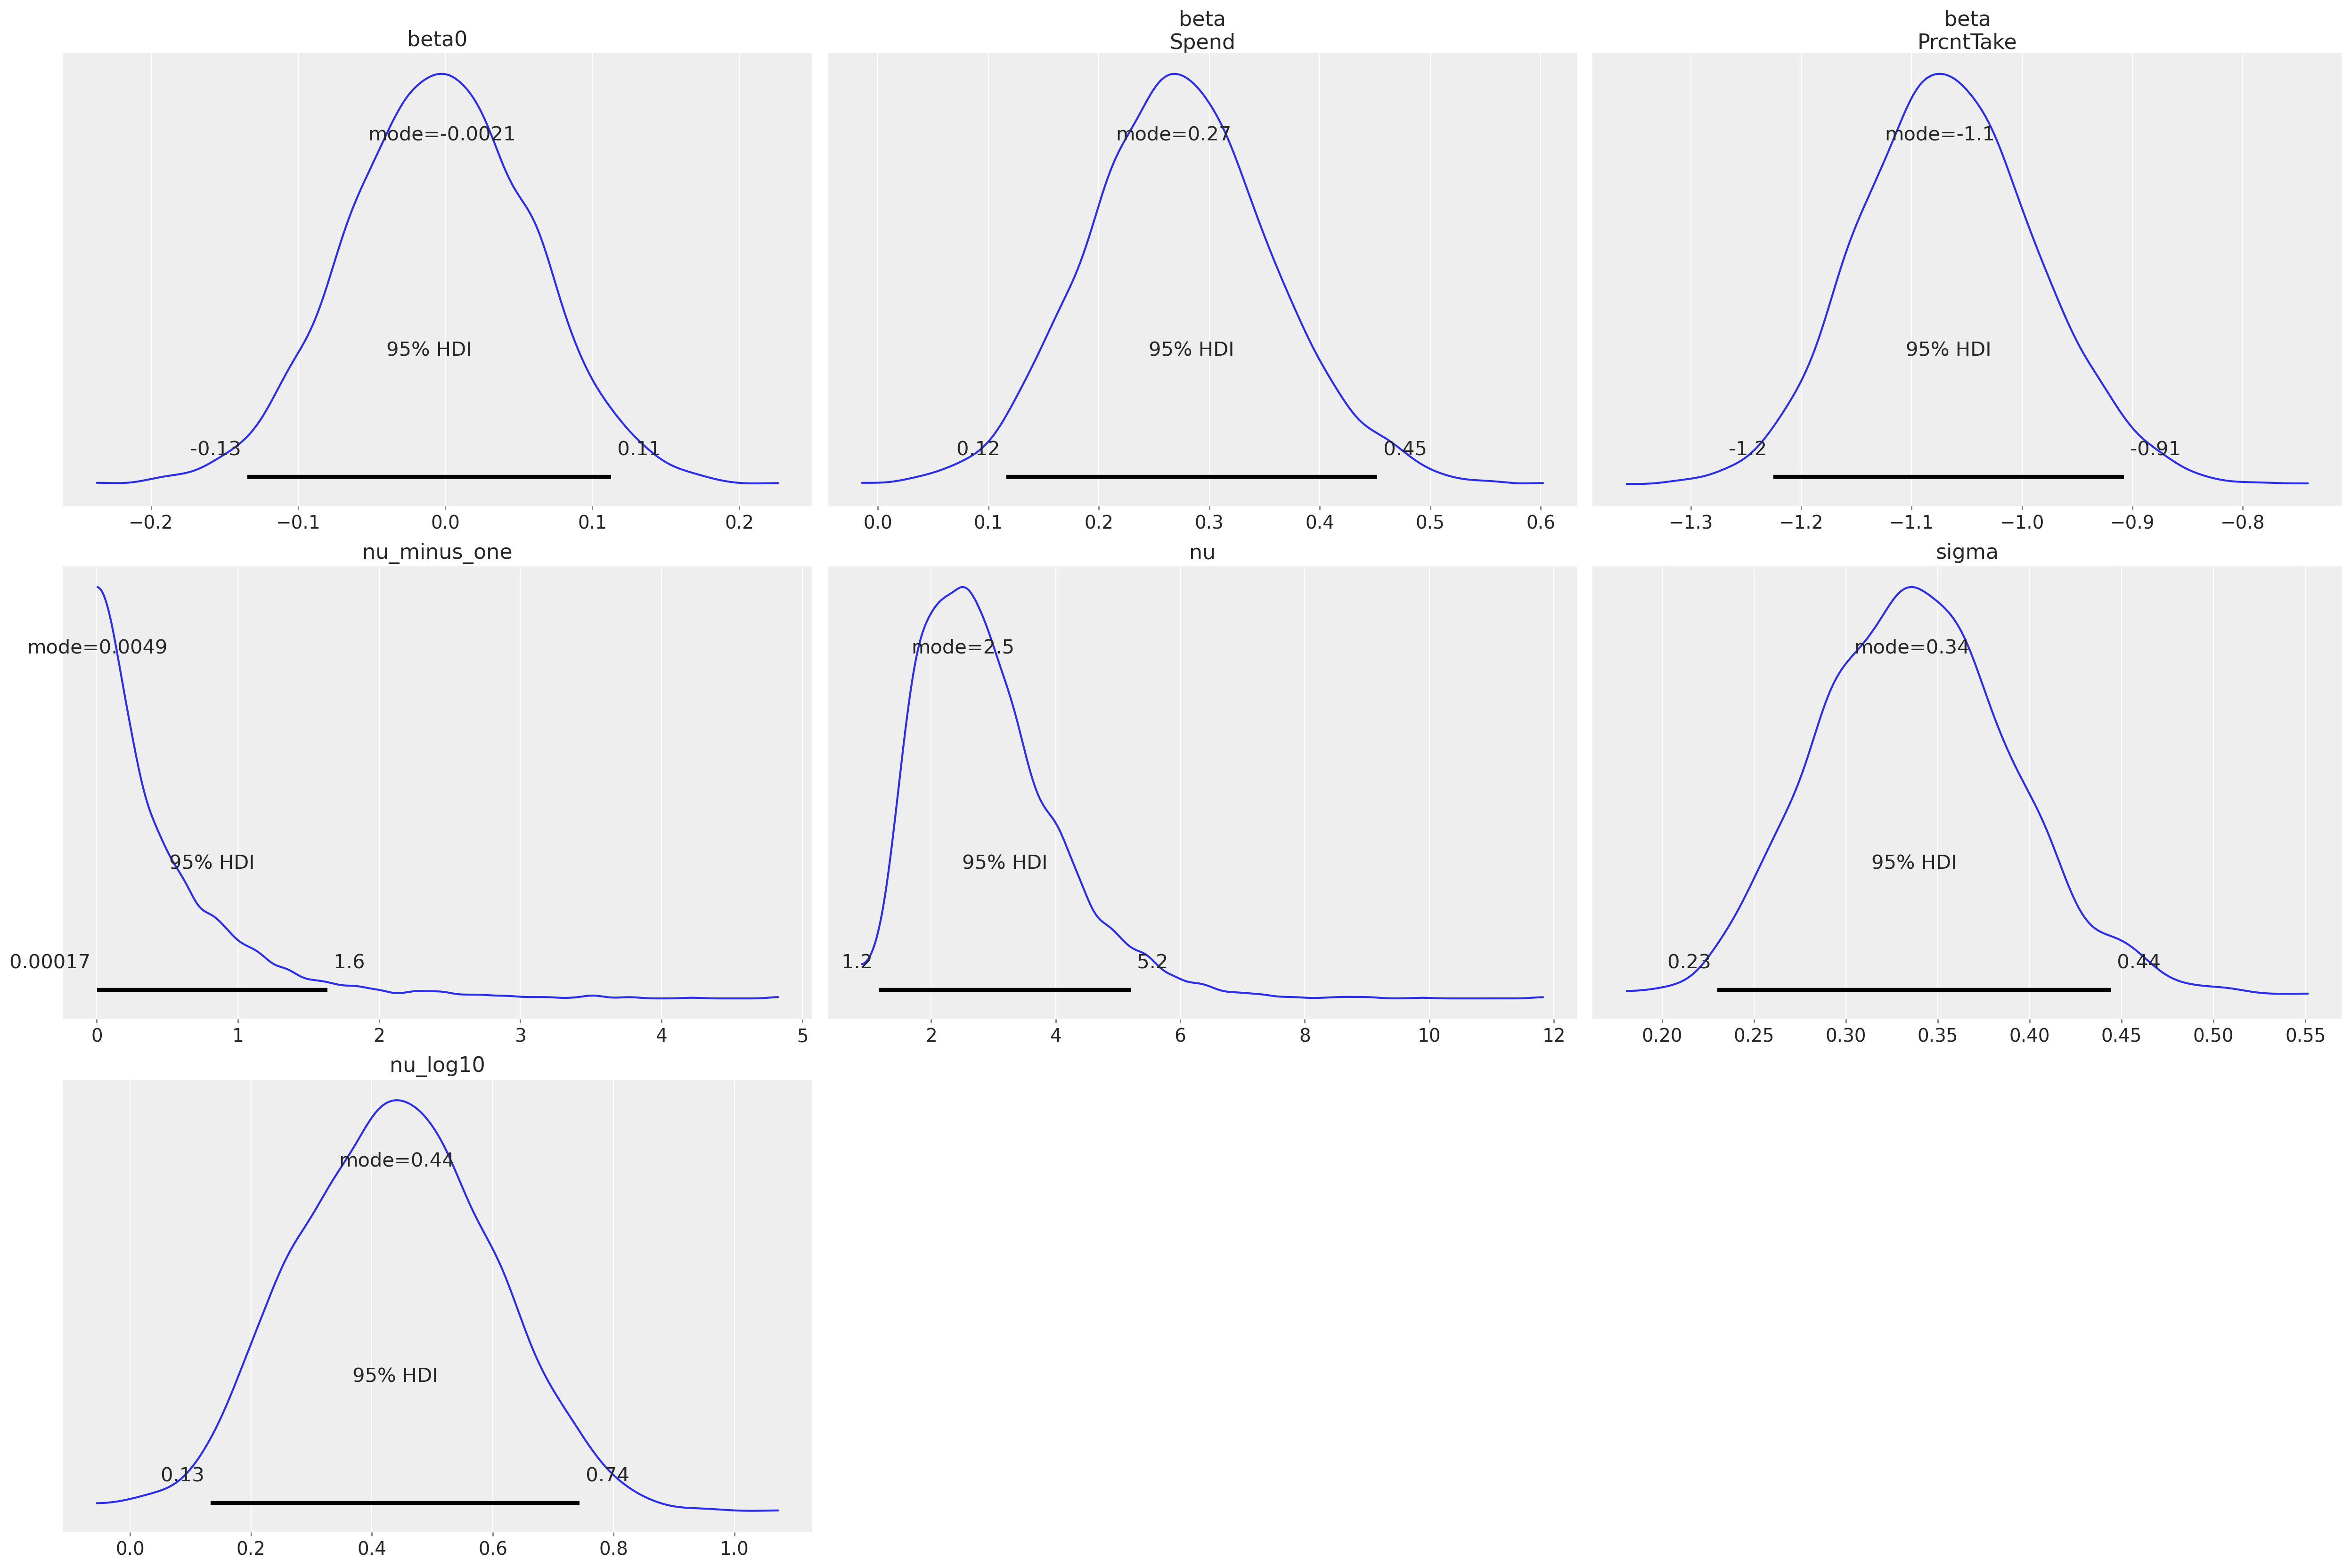

In [9]:
az.plot_posterior(idata, point_estimate="mode");

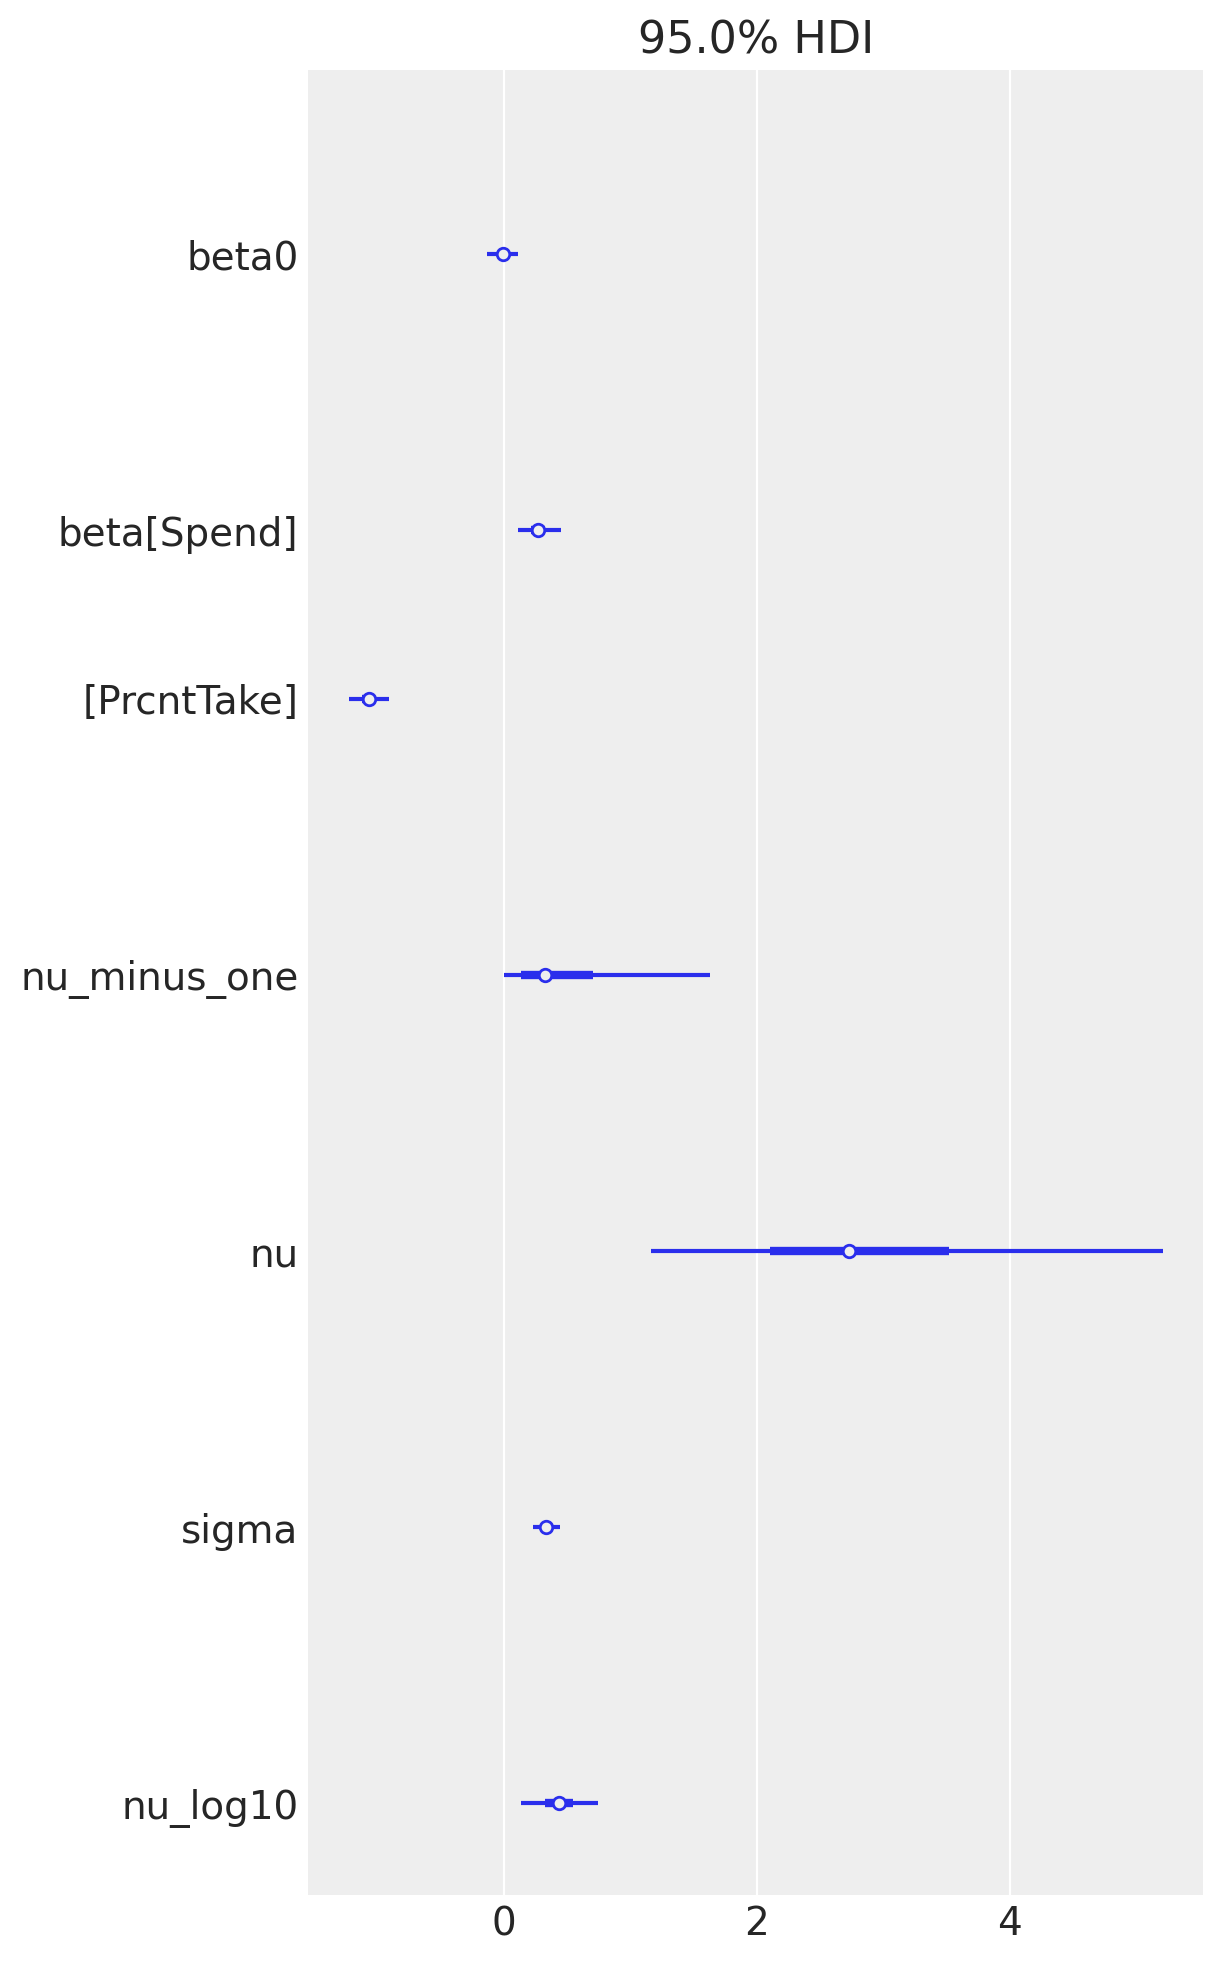

In [10]:
az.plot_forest(idata, combined=True);

In [11]:
# Get the dataset corresponding to a single "group" (see: https://arviz-devs.github.io/arviz/getting_started/WorkingWithInferenceData.html#add-a-new-variable)
post = idata.posterior

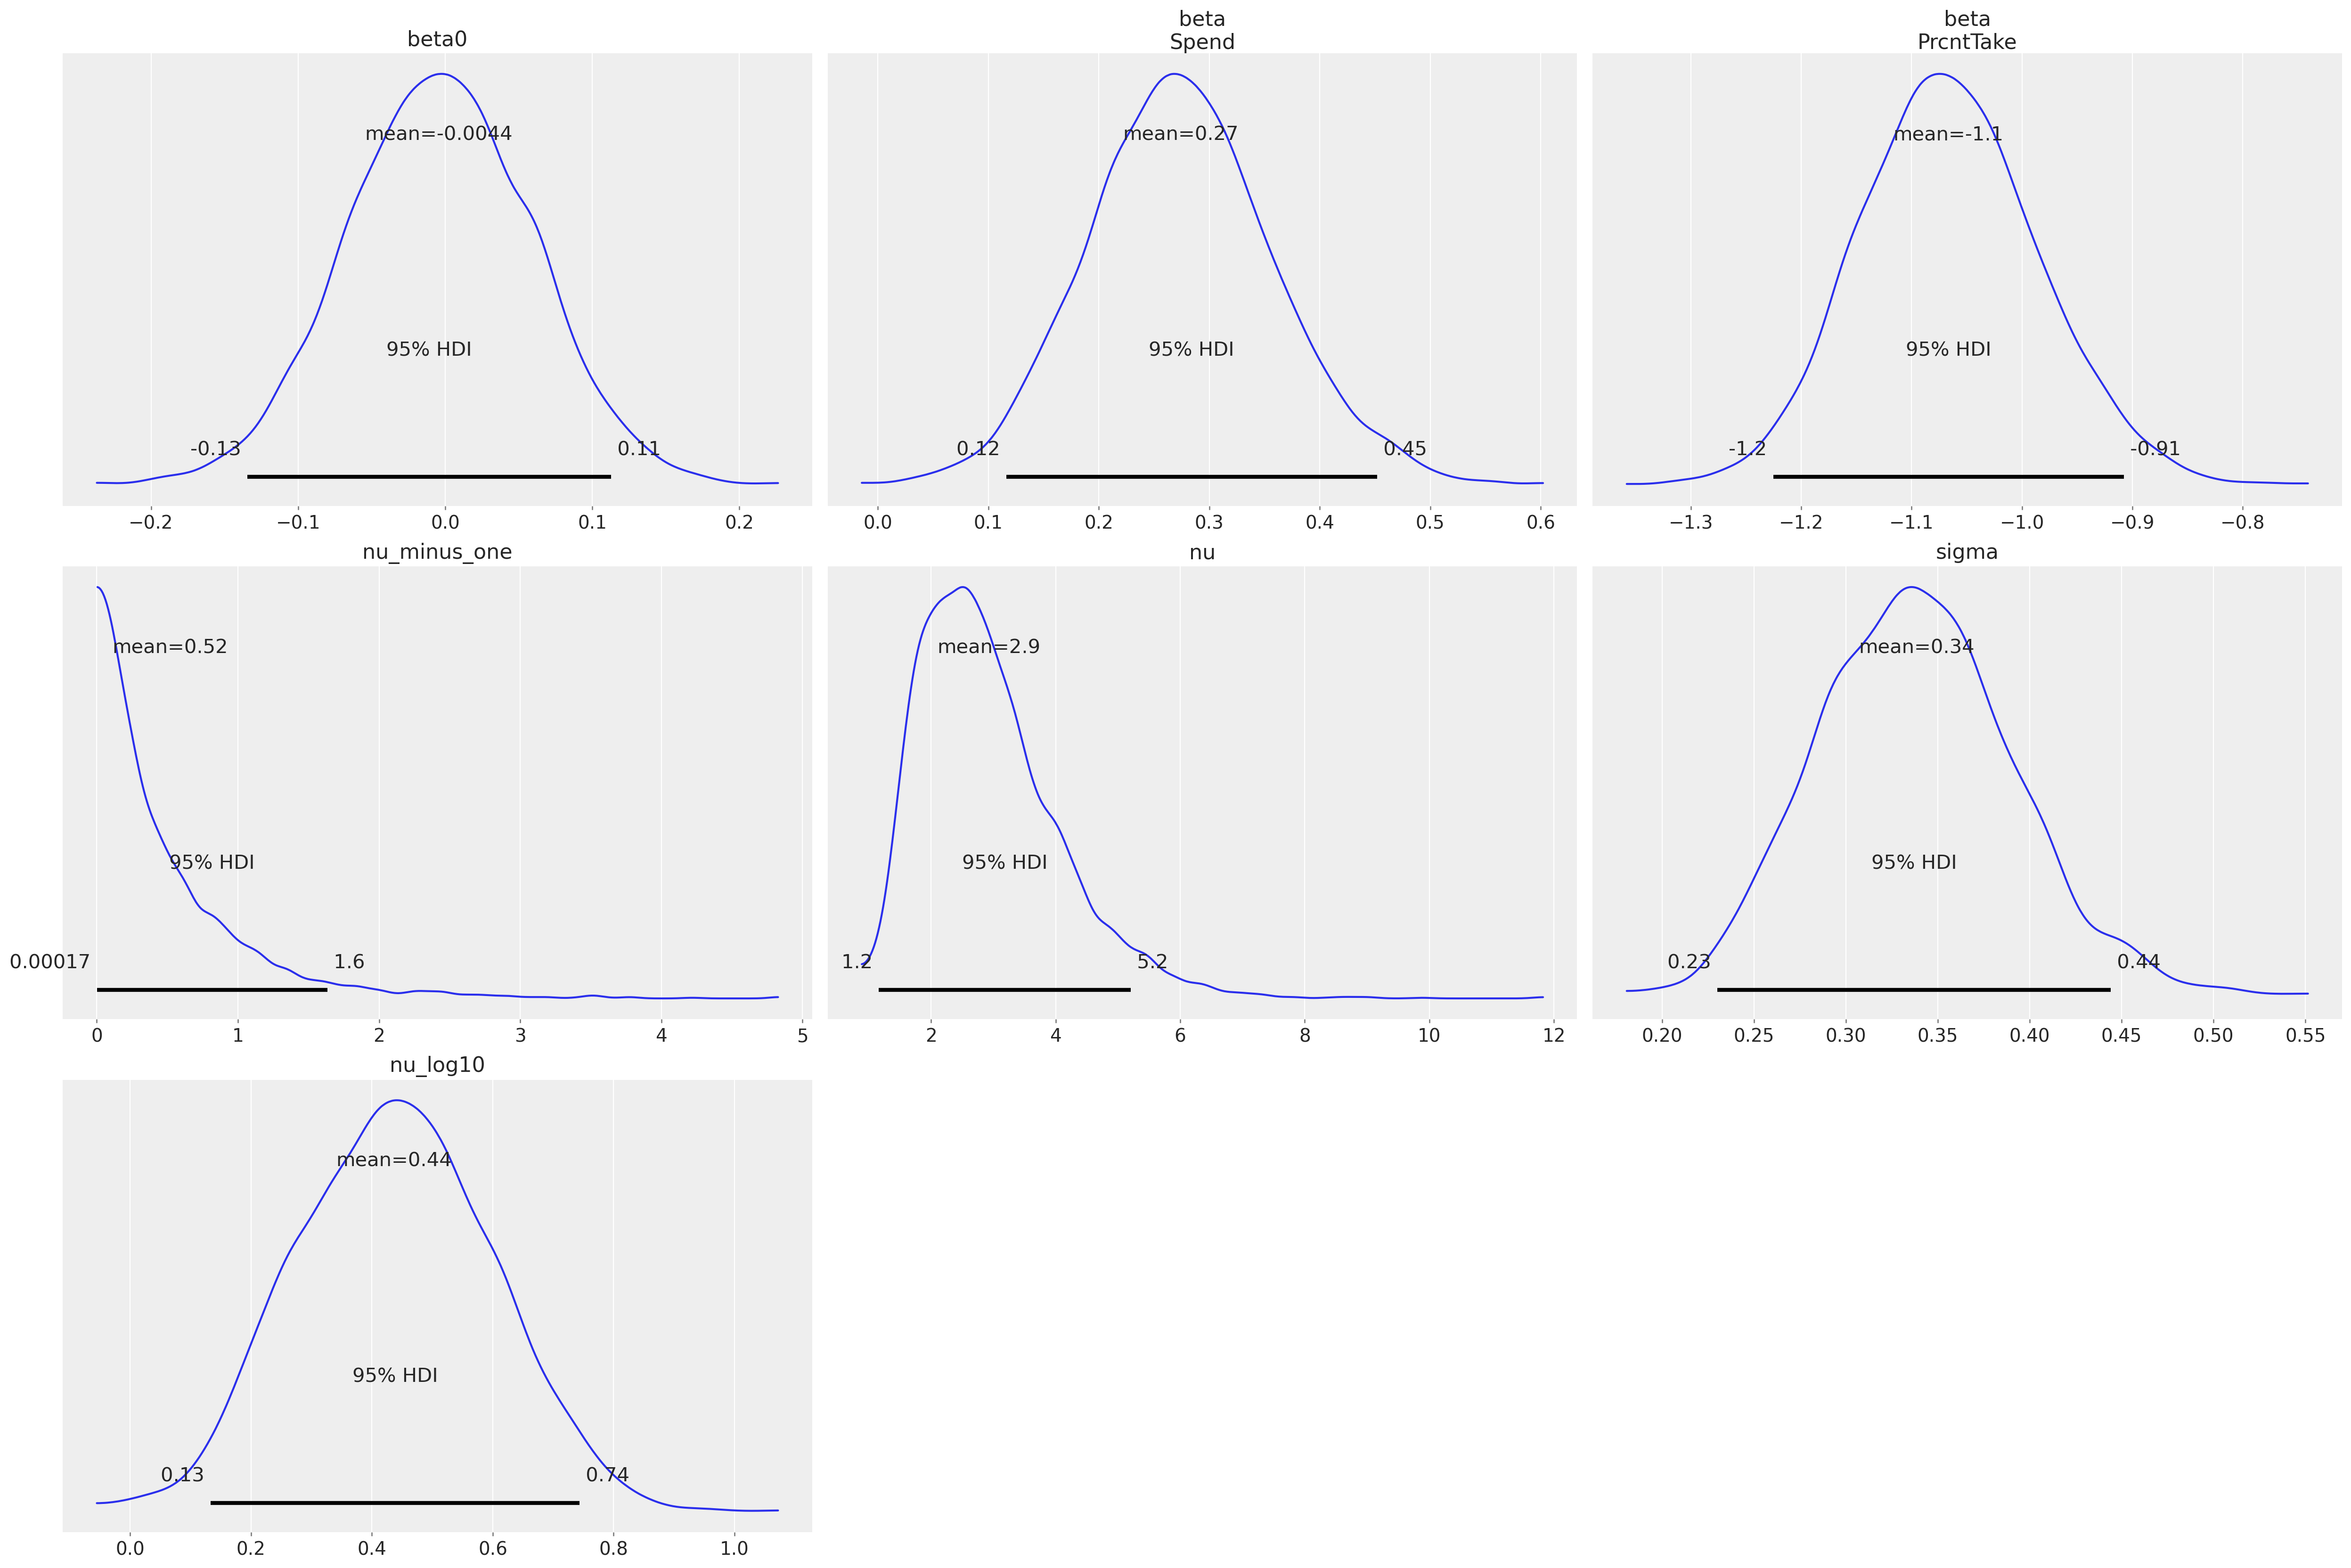

In [12]:
az.plot_posterior(post);

In [13]:
# import xarray as xr
# post["dummy"] = xr.DataArray(np.random.standard_normal((4, 1000)), dims=["chain", "draw"])
# post

In [14]:
post.dims

Frozen({'chain': 4, 'draw': 1000, 'predictors': 2})

In [15]:
stacked = az.extract(post)
stacked

<xarray.Dataset>
Dimensions:       (sample: 4000, predictors: 2)
Coordinates:
  * predictors    (predictors) <U9 'Spend' 'PrcntTake'
  * sample        (sample) object MultiIndex
  * chain         (sample) int64 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw          (sample) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    beta0         (sample) float64 -0.04985 0.01524 ... -0.02117 -0.08333
    beta          (predictors, sample) float64 0.312 0.4508 ... -1.254 -1.152
    nu_minus_one  (sample) float64 0.04047 0.03891 2.282 ... 0.1002 1.896 1.107
    nu            (sample) float64 2.313 3.603 2.191 3.07 ... 1.816 1.06 1.675
    sigma         (sample) float64 0.3553 0.3275 0.3581 ... 0.1805 0.2101 0.2384
    nu_log10      (sample) float64 0.3642 0.5566 0.3406 ... 0.02523 0.2241
Attributes:
    created_at:                 2022-11-04T19:48:30.062141
    arviz_version:              0.13.0
    inference_library:          pymc
    inference_library_version:  4.2.2
    sampling_time:              20.261294841766357
    tuning_steps:               1000

In [16]:
type(stacked["beta"])
stacked["beta"].shape

(2, 4000)

In [17]:
stacked["beta0_raw"], stacked["beta1_raw"], stacked["sigma_raw"] = bst.unstandardize_multiple_linreg_parameters(stacked["beta0"], stacked["beta"], mu_X, mu_y, stacked["sigma"], sigma_X, sigma_y)

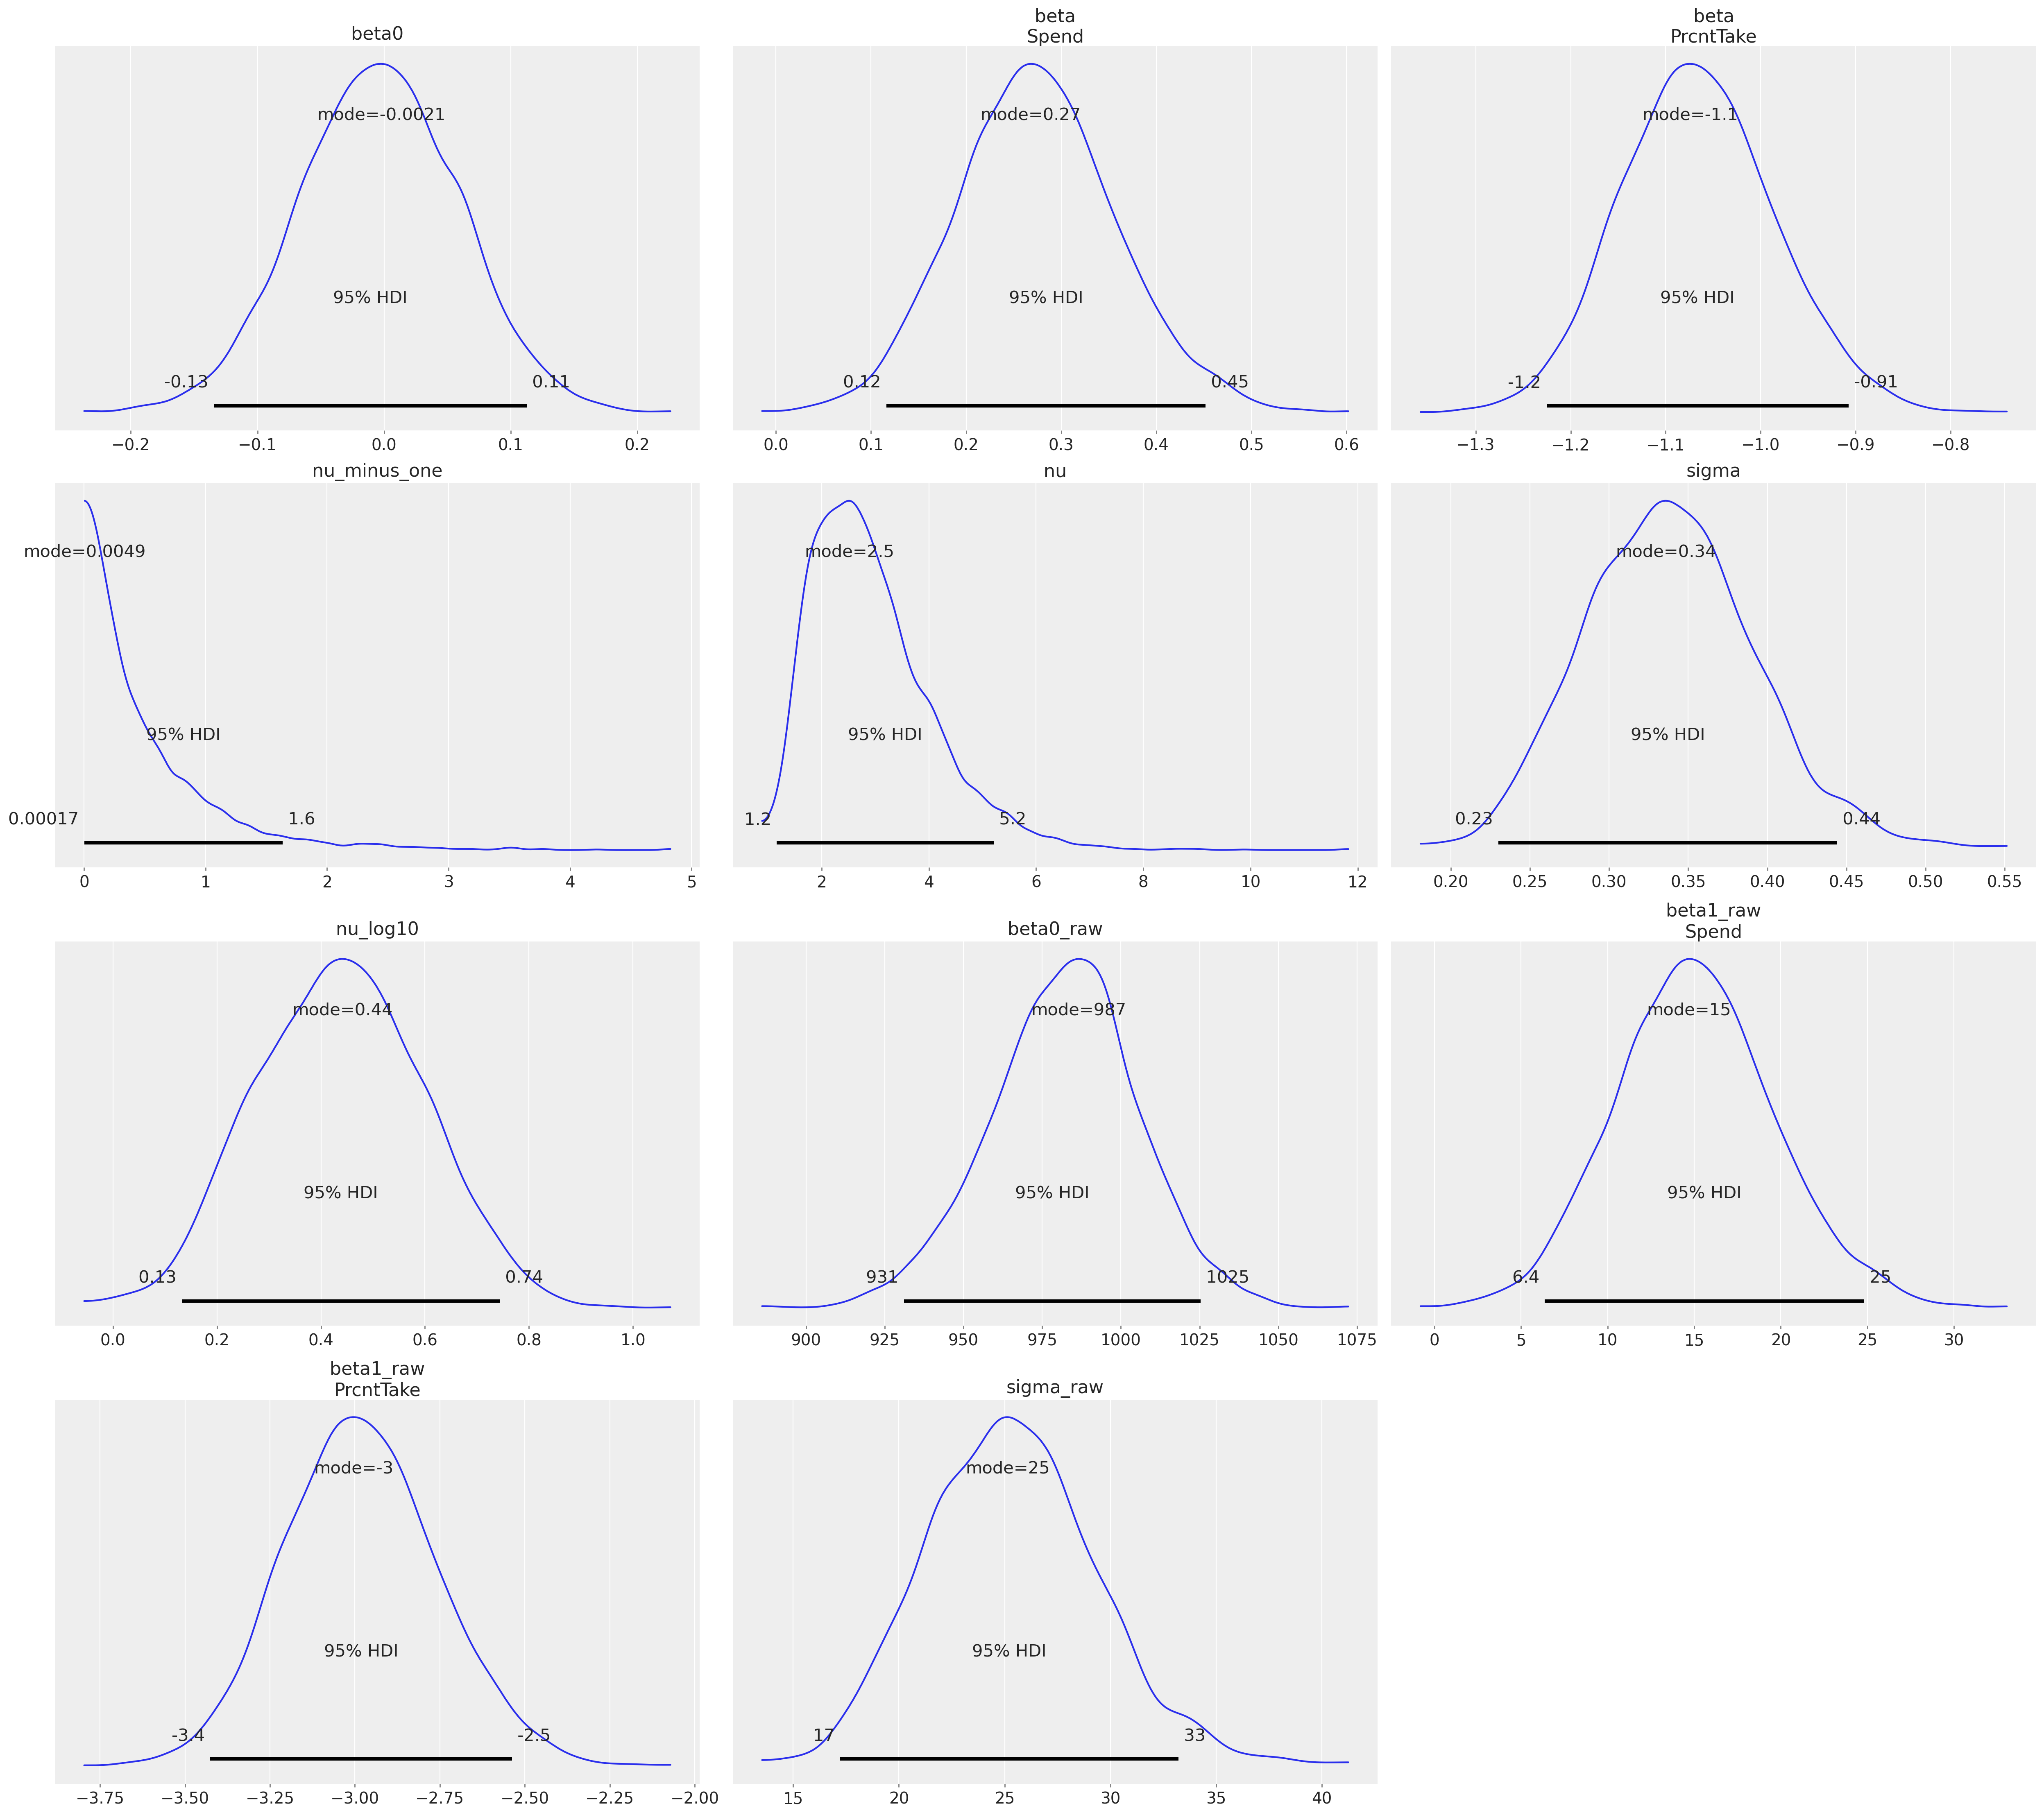

In [18]:
az.plot_posterior(stacked, combine_dims={"sample"}, point_estimate="mode");

In [19]:
unstacked = stacked.unstack()
# unstacked

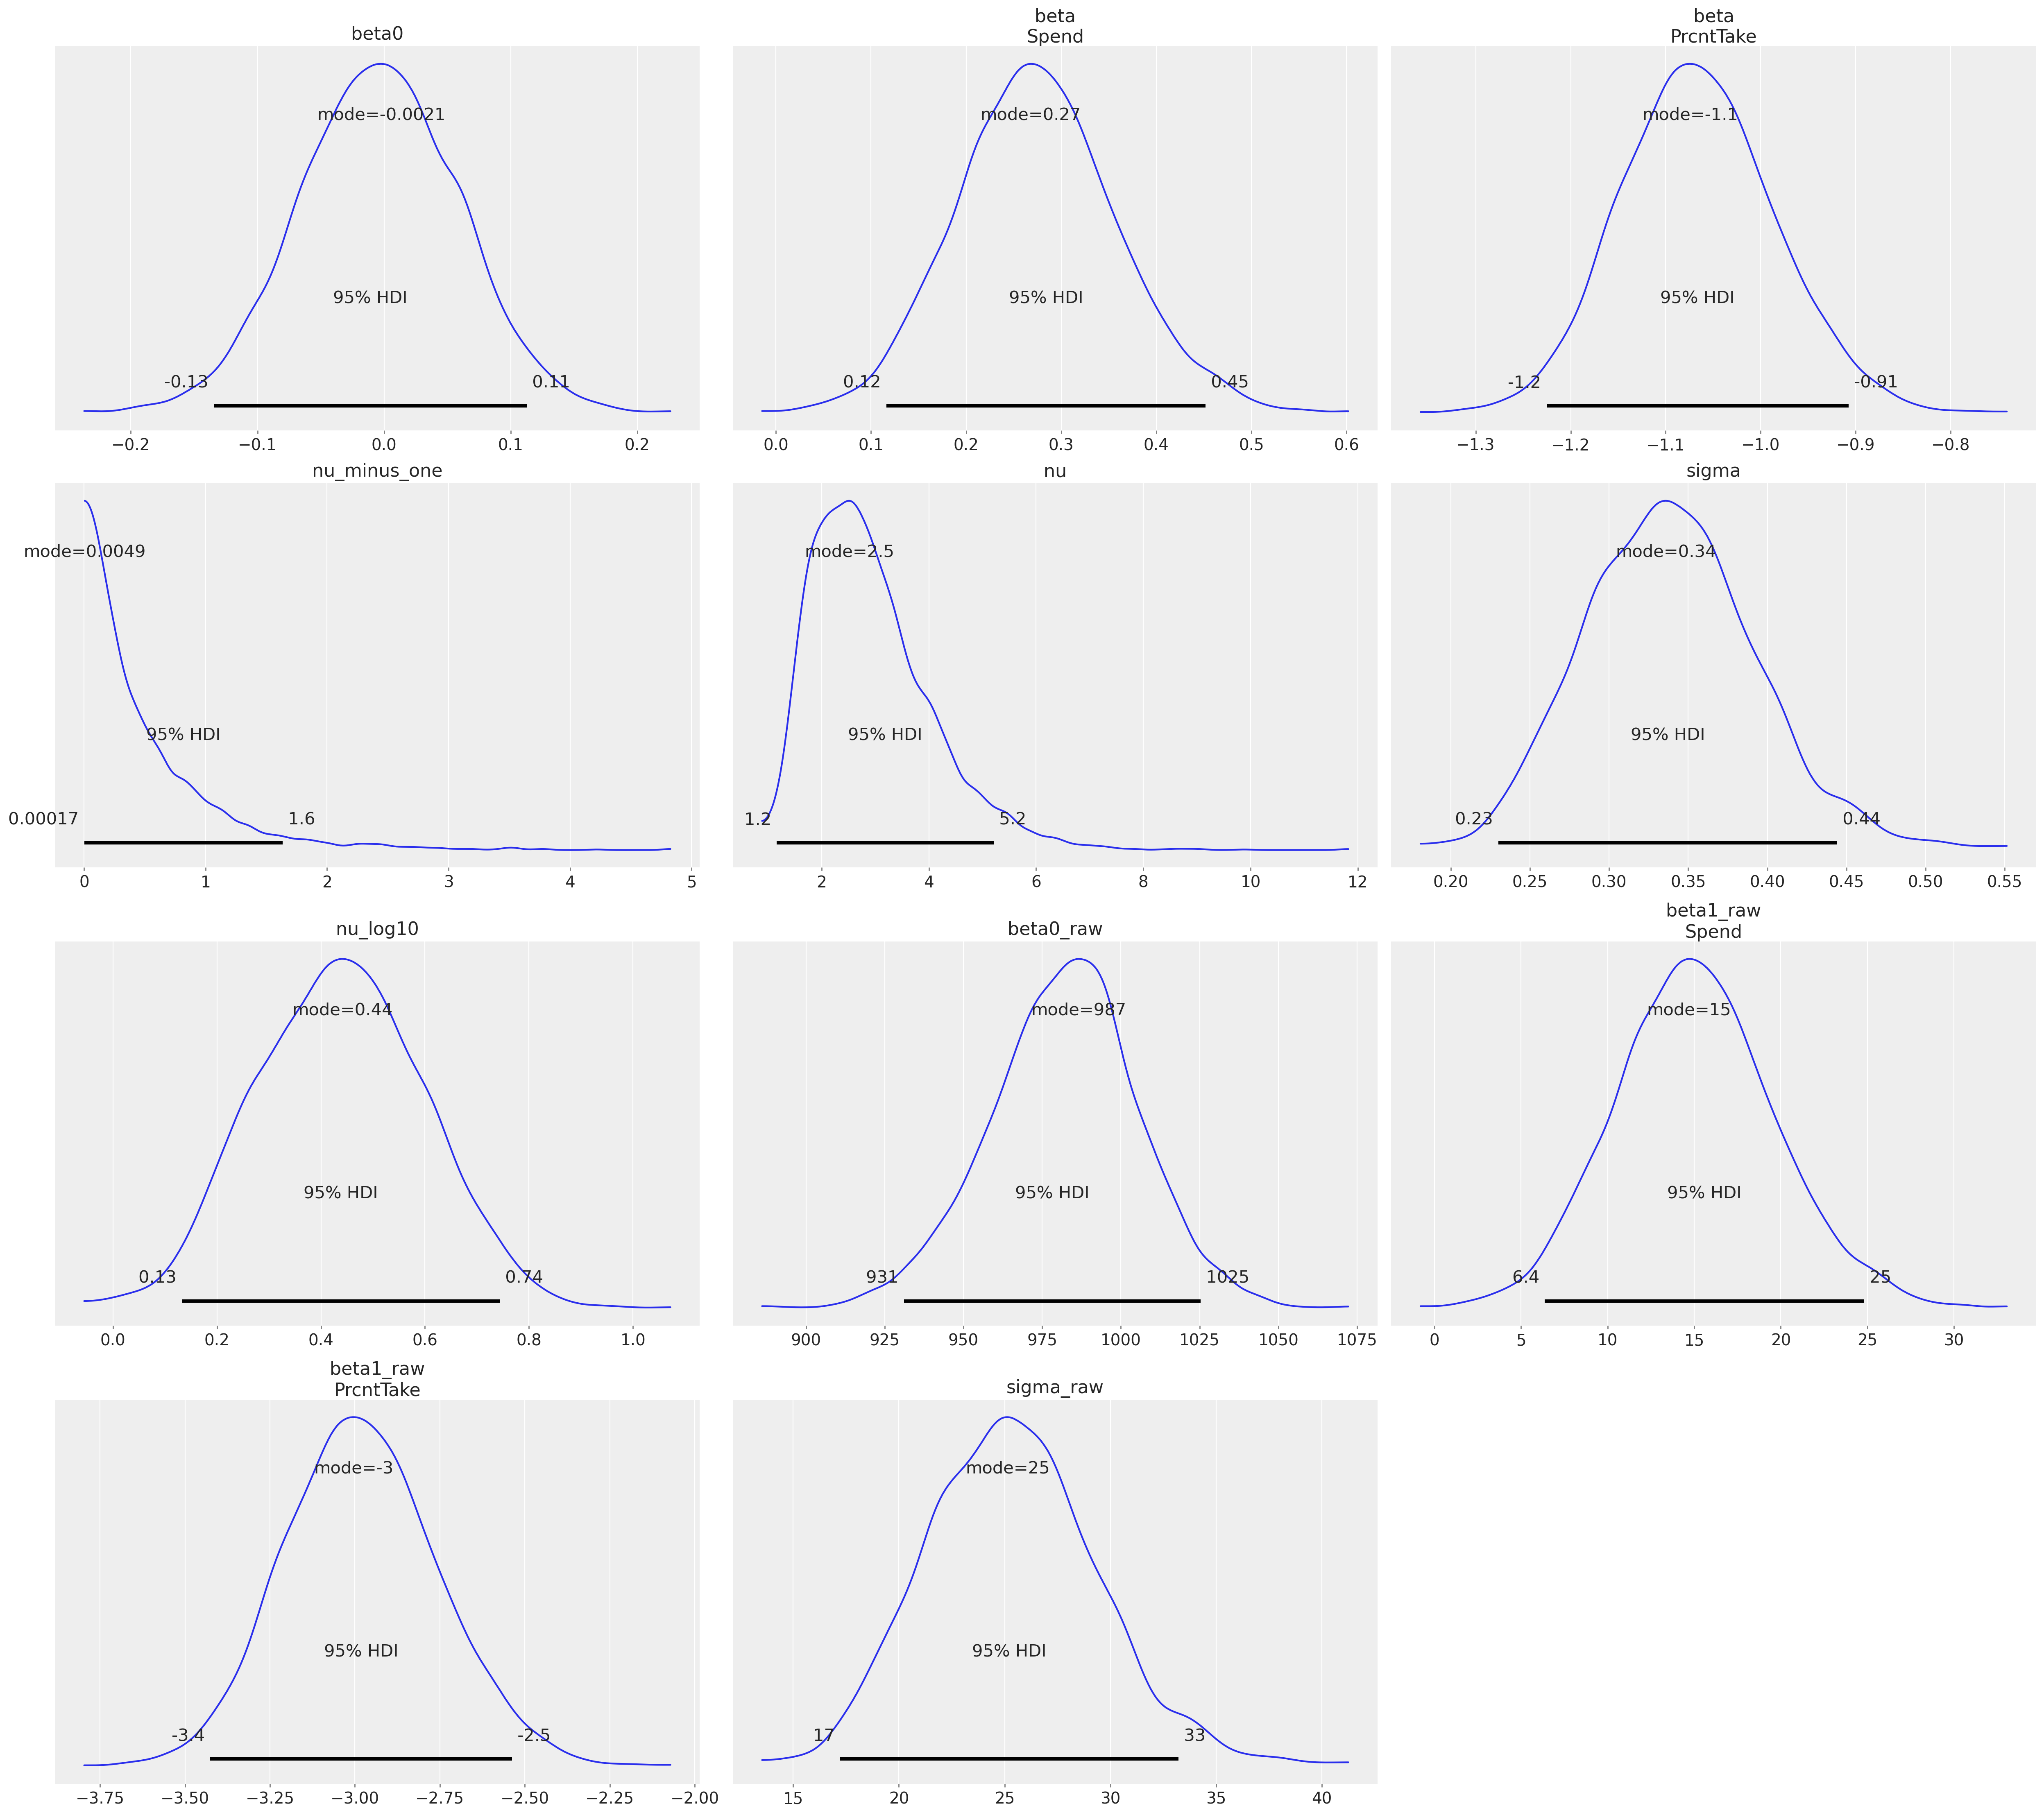

In [20]:
az.plot_posterior(unstacked, point_estimate="mode");

In [21]:
stacked

<xarray.Dataset>
Dimensions:       (predictors: 2, sample: 4000)
Coordinates:
  * predictors    (predictors) <U9 'Spend' 'PrcntTake'
  * sample        (sample) object MultiIndex
  * chain         (sample) int64 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw          (sample) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    beta0         (sample) float64 -0.04985 0.01524 ... -0.02117 -0.08333
    beta          (predictors, sample) float64 0.312 0.4508 ... -1.254 -1.152
    nu_minus_one  (sample) float64 0.04047 0.03891 2.282 ... 0.1002 1.896 1.107
    nu            (sample) float64 2.313 3.603 2.191 3.07 ... 1.816 1.06 1.675
    sigma         (sample) float64 0.3553 0.3275 0.3581 ... 0.1805 0.2101 0.2384
    nu_log10      (sample) float64 0.3642 0.5566 0.3406 ... 0.02523 0.2241
    beta0_raw     (sample) float64 972.1 929.4 959.5 950.0 ... 931.1 961.6 970.9
    beta1_raw     (sample, predictors) float64 17.13 -3.152 ... 17.32 -3.221
    sigma_raw     (sample) float64 26.58 24.51 26.79 21.08 ... 13.5 15.72 17.84
Attributes:
    created_at:                 2022-11-04T19:48:30.062141
    arviz_version:              0.13.0
    inference_library:          pymc
    inference_library_version:  4.2.2
    sampling_time:              20.261294841766357
    tuning_steps:               1000